[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を参考に、エージェントを作成する。FXの自動取引を行い、利益を出すのが目標。

In [ ]:
import matplotlib as mpl
mpl.use('tkagg')
import numpy as np
import pandas as pd
import talib
from logging import getLogger, DEBUG, INFO, WARN, ERROR, CRITICAL
import os
import logging
from logging import StreamHandler, LogRecord
from episode_logger import EpisodeLogger
from test_output_logger import TestOutputLogger

from hist_data import HistData, BitcoinHistData
from fx_trade import FXTrade
from bitcoin_trade import BitcoinTrade
from deep_fx import DeepFX
from debug_tools import DebugTools

Using TensorFlow backend.


In [ ]:
import crcmod
class LogRecordWithHexThereadID(logging.LogRecord):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hex_threadid = self._calc_hex(self.process)

    def _calc_hex(self, digit_value):
        return hex(digit_value)

def init_logger(sd_loglevel=logging.WARN, stream_loglevel=logging.CRITICAL):
    logging.setLogRecordFactory(LogRecordWithHexThereadID)
    logger = logging.getLogger('deepfx')
    logger.setLevel(sd_loglevel)
    formatter = logging.Formatter('[%(hex_threadid)s] %(message)s')

    if sd_loglevel:
        import google
        from google.cloud.logging import Client
        from google.cloud.logging.handlers import CloudLoggingHandler
        client = google.cloud.logging.Client \
            .from_service_account_json(os.environ.get('GOOGLE_SERVICE_ACCOUNT_JSON_PATH'))
        handler = CloudLoggingHandler(client, name='deepfx')
        handler.setLevel(sd_loglevel)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = None

    if stream_loglevel:
        handler = StreamHandler()
        handler.setLevel(stream_loglevel)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = None

    return logger

In [ ]:
deepfx_logger = init_logger(stream_loglevel=None)
deepfx_logger.critical('DeepFX Started: %s' % DebugTools.now_str())
deepfx_logger.debug   ('loglevel debug    test')
deepfx_logger.info    ('loglevel info     test')
deepfx_logger.warning ('loglevel warn     test')
deepfx_logger.error   ('loglevel error    test')
deepfx_logger.critical('loglevel critical test')

In [ ]:
is_for_fx = False
is_for_bitcoin = True
is_to_train = True

In [ ]:
if is_for_fx:
    hd = HistData(csv_path = 'historical_data/DAT_ASCII_USDJPY_M1_201710_h1.csv',
                     begin_date='2017-10-02T00:00:00',
                     end_date='2017-10-02T01:59:59')
elif is_for_bitcoin:
    csv_path = 'historical_data/coincheckJPY_1-min_data_2014-10-31_to_2017-10-20_h1.csv'
    if is_to_train:
        begin_date='2017-09-01T00:00:00'
        end_date='2017-09-30T23:59:59'
    else:
        begin_date='2017-10-01T00:00:00'
        end_date='2017-10-10T23:59:59'
        
    hd = HistData(csv_path, begin_date, end_date)


header is included


In [ ]:
hd.data()
len(hd.data())

720

In [ ]:
if is_for_fx:
    env = FXTrade(1000000, 0.08, hd, logger=deepfx_logger)
    #env = FXTrade(1000000, 0.08, h, logger=logger)
    prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq1.440944e+06_episode00003.h5'
    dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 1000000, logger=deepfx_logger)
elif is_for_bitcoin:
    env = BitcoinTrade(10000000, None, hd, logger=deepfx_logger, amount_unit=0.001)
    #env = FXTrade(1000000, 0.08, h, logger=logger)
    prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq2.149058e+07_episode05184.h5'
    dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 10000000, logger=deepfx_logger)
    #dfx = DeepFX(env, prepared_model_filename=prepared_model_filename, steps = 1000, logger=deepfx_logger)

In [ ]:
if is_to_train:
    dfx.train(is_for_time_measurement=True)
else:
    dfx.test([TestOutputLogger(hd)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 128)            384       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 33,795
Trainable params: 33,795
Non-trainable params: 0
_________________________________________________________________
Training for 10000000 steps ...
Training for 10000000 steps ...
     719/10000000: episode: 1, duration: 4.915s, episode steps: 719, steps

    9347/10000000: episode: 13, duration: 4.441s, episode steps: 719, steps per second: 162, episode reward: 14510.732, mean reward: 20.182 [0.000, 27.899], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 2068.396240, mean_absolute_error: 52.688892, mean_q: -7.005064
    9347/10000000: episode: 13, duration: 4.446s, episode steps: 719, steps per second: 162, episode reward: 14510.732, mean reward: 20.182 [0.000, 27.899], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 2068.396240, mean_absolute_error: 52.688892, mean_q: -7.005064
   10066/10000000: episode: 14, duration: 4.383s, episode steps: 719, steps per second: 164, episode reward: 393.164, mean reward: 0.547 [-11.533, 9.201], mean action: 0.086 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 1932.564453, mean_absolute_error: 51.465130, mean_q: -5.623082
   10066/10000000: episode: 14, duration: 4.389s, episode steps: 719,

   19413/10000000: episode: 27, duration: 4.225s, episode steps: 719, steps per second: 170, episode reward: 7947.487, mean reward: 11.054 [-5.225, 29.193], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 1116.456055, mean_absolute_error: 35.051815, mean_q: -7.158898
   19413/10000000: episode: 27, duration: 4.231s, episode steps: 719, steps per second: 170, episode reward: 7947.487, mean reward: 11.054 [-5.225, 29.193], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 1116.456055, mean_absolute_error: 35.051815, mean_q: -7.158898
   20132/10000000: episode: 28, duration: 5.292s, episode steps: 719, steps per second: 136, episode reward: 7172.515, mean reward: 9.976 [0.000, 22.661], mean action: 0.095 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 1032.350952, mean_absolute_error: 35.049686, mean_q: -6.625061
   20132/10000000: episode: 28, duration: 5.298s, episode steps: 719,

   29479/10000000: episode: 41, duration: 5.384s, episode steps: 719, steps per second: 134, episode reward: 1930.489, mean reward: 2.685 [-8.496, 12.433], mean action: 0.074 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 769.537720, mean_absolute_error: 28.475180, mean_q: -9.115963
   29479/10000000: episode: 41, duration: 5.388s, episode steps: 719, steps per second: 133, episode reward: 1930.489, mean reward: 2.685 [-8.496, 12.433], mean action: 0.074 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 769.537720, mean_absolute_error: 28.475180, mean_q: -9.115963
   30198/10000000: episode: 42, duration: 4.686s, episode steps: 719, steps per second: 153, episode reward: -15324.672, mean reward: -21.314 [-33.929, 0.000], mean action: 0.083 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 825.630371, mean_absolute_error: 28.418154, mean_q: -10.118751
   30198/10000000: episode: 42, duration: 4.689s, episode steps: 719

   39545/10000000: episode: 55, duration: 5.440s, episode steps: 719, steps per second: 132, episode reward: 2913.539, mean reward: 4.052 [-4.589, 14.152], mean action: 0.085 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 694.621460, mean_absolute_error: 26.862251, mean_q: -14.207823
   39545/10000000: episode: 55, duration: 5.443s, episode steps: 719, steps per second: 132, episode reward: 2913.539, mean reward: 4.052 [-4.589, 14.152], mean action: 0.085 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 694.621460, mean_absolute_error: 26.862251, mean_q: -14.207823
   40264/10000000: episode: 56, duration: 4.751s, episode steps: 719, steps per second: 151, episode reward: -6420.854, mean reward: -8.930 [-24.501, 9.342], mean action: 0.076 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 686.858704, mean_absolute_error: 27.790518, mean_q: -15.774299
   40264/10000000: episode: 56, duration: 4.756s, episode steps: 719

   49611/10000000: episode: 69, duration: 4.561s, episode steps: 719, steps per second: 158, episode reward: 12571.441, mean reward: 17.485 [-5.306, 41.672], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 555.614685, mean_absolute_error: 28.149675, mean_q: -17.184885
   49611/10000000: episode: 69, duration: 4.566s, episode steps: 719, steps per second: 157, episode reward: 12571.441, mean reward: 17.485 [-5.306, 41.672], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 555.614685, mean_absolute_error: 28.149675, mean_q: -17.184885
   50330/10000000: episode: 70, duration: 4.630s, episode steps: 719, steps per second: 155, episode reward: -12895.957, mean reward: -17.936 [-30.003, 0.000], mean action: 0.095 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 589.672180, mean_absolute_error: 27.936417, mean_q: -17.589983
   50330/10000000: episode: 70, duration: 4.635s, episode step

   59677/10000000: episode: 83, duration: 4.993s, episode steps: 719, steps per second: 144, episode reward: 24078.973, mean reward: 33.490 [0.000, 44.901], mean action: 0.078 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 537.114136, mean_absolute_error: 26.596102, mean_q: -19.100164
   59677/10000000: episode: 83, duration: 4.997s, episode steps: 719, steps per second: 144, episode reward: 24078.973, mean reward: 33.490 [0.000, 44.901], mean action: 0.078 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 537.114136, mean_absolute_error: 26.596102, mean_q: -19.100164
   60396/10000000: episode: 84, duration: 4.869s, episode steps: 719, steps per second: 148, episode reward: 17766.464, mean reward: 24.710 [-24.648, 59.942], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 514.046509, mean_absolute_error: 26.656446, mean_q: -19.303453
   60396/10000000: episode: 84, duration: 4.875s, episode steps: 

   69743/10000000: episode: 97, duration: 5.239s, episode steps: 719, steps per second: 137, episode reward: -2741.737, mean reward: -3.813 [-15.286, 14.529], mean action: 0.113 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 508.144196, mean_absolute_error: 26.413994, mean_q: -20.635984
   69743/10000000: episode: 97, duration: 5.243s, episode steps: 719, steps per second: 137, episode reward: -2741.737, mean reward: -3.813 [-15.286, 14.529], mean action: 0.113 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 508.144196, mean_absolute_error: 26.413994, mean_q: -20.635984
   70462/10000000: episode: 98, duration: 5.441s, episode steps: 719, steps per second: 132, episode reward: 12579.028, mean reward: 17.495 [0.000, 28.441], mean action: 0.107 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 522.238892, mean_absolute_error: 28.344667, mean_q: -22.764881
   70462/10000000: episode: 98, duration: 5.450s, episode steps

   79809/10000000: episode: 111, duration: 4.677s, episode steps: 719, steps per second: 154, episode reward: 19263.187, mean reward: 26.792 [0.000, 38.527], mean action: 0.111 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 427.038696, mean_absolute_error: 28.738859, mean_q: -24.493456
   79809/10000000: episode: 111, duration: 4.688s, episode steps: 719, steps per second: 153, episode reward: 19263.187, mean reward: 26.792 [0.000, 38.527], mean action: 0.111 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 427.038696, mean_absolute_error: 28.738859, mean_q: -24.493456
   80528/10000000: episode: 112, duration: 4.804s, episode steps: 719, steps per second: 150, episode reward: -11548.889, mean reward: -16.062 [-24.788, 0.000], mean action: 0.096 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 475.998749, mean_absolute_error: 28.860060, mean_q: -27.069731
   80528/10000000: episode: 112, duration: 4.808s, episode st

   89875/10000000: episode: 125, duration: 4.743s, episode steps: 719, steps per second: 152, episode reward: -1047169.847, mean reward: -1456.425 [-4302.615, 748.269], mean action: 1.914 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10763.952148, mean_absolute_error: 23.112051, mean_q: -0.264529
   89875/10000000: episode: 125, duration: 4.746s, episode steps: 719, steps per second: 151, episode reward: -1047169.847, mean reward: -1456.425 [-4302.615, 748.269], mean action: 1.914 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10763.952148, mean_absolute_error: 23.112051, mean_q: -0.264529
   90594/10000000: episode: 126, duration: 4.491s, episode steps: 719, steps per second: 160, episode reward: -950256.412, mean reward: -1321.636 [-4295.142, 540.693], mean action: 1.495 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 21246.439453, mean_absolute_error: 31.986238, mean_q: -15.932722
   90594/10000000: episode: 

   99222/10000000: episode: 138, duration: 4.110s, episode steps: 719, steps per second: 175, episode reward: -8076.367, mean reward: -11.233 [-31.234, 16.166], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 31743.115234, mean_absolute_error: 105.910019, mean_q: -39.680229
   99222/10000000: episode: 138, duration: 4.114s, episode steps: 719, steps per second: 175, episode reward: -8076.367, mean reward: -11.233 [-31.234, 16.166], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 31743.115234, mean_absolute_error: 105.910019, mean_q: -39.680229
   99941/10000000: episode: 139, duration: 4.111s, episode steps: 719, steps per second: 175, episode reward: -3013.366, mean reward: -4.191 [-17.752, 12.382], mean action: 0.110 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 24873.273438, mean_absolute_error: 104.773666, mean_q: -39.144787
   99941/10000000: episode: 139, duration: 4.11

  108569/10000000: episode: 151, duration: 4.161s, episode steps: 719, steps per second: 173, episode reward: -10382.531, mean reward: -14.440 [-104.537, 63.901], mean action: 0.994 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 22733.880859, mean_absolute_error: 108.232368, mean_q: -55.488853
  108569/10000000: episode: 151, duration: 4.165s, episode steps: 719, steps per second: 173, episode reward: -10382.531, mean reward: -14.440 [-104.537, 63.901], mean action: 0.994 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 22733.880859, mean_absolute_error: 108.232368, mean_q: -55.488853
  109288/10000000: episode: 152, duration: 4.113s, episode steps: 719, steps per second: 175, episode reward: -12912.209, mean reward: -17.959 [-90.177, 27.785], mean action: 0.267 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 25323.716797, mean_absolute_error: 105.705605, mean_q: -49.221226
  109288/10000000: episode: 152, duration

  117916/10000000: episode: 164, duration: 4.054s, episode steps: 719, steps per second: 177, episode reward: -715.310, mean reward: -0.995 [-8.736, 7.126], mean action: 0.092 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 23623.060547, mean_absolute_error: 120.177849, mean_q: -67.626442
  117916/10000000: episode: 164, duration: 4.058s, episode steps: 719, steps per second: 177, episode reward: -715.310, mean reward: -0.995 [-8.736, 7.126], mean action: 0.092 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 23623.060547, mean_absolute_error: 120.177849, mean_q: -67.626442
  118635/10000000: episode: 165, duration: 4.177s, episode steps: 719, steps per second: 172, episode reward: -10625.641, mean reward: -14.778 [-30.970, 14.665], mean action: 0.090 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 23378.656250, mean_absolute_error: 118.035919, mean_q: -67.222832
  118635/10000000: episode: 165, duration: 4.181s, ep

  127263/10000000: episode: 177, duration: 4.125s, episode steps: 719, steps per second: 174, episode reward: 382.642, mean reward: 0.532 [-14.508, 16.925], mean action: 0.092 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 22339.457031, mean_absolute_error: 125.679832, mean_q: -76.882088
  127263/10000000: episode: 177, duration: 4.129s, episode steps: 719, steps per second: 174, episode reward: 382.642, mean reward: 0.532 [-14.508, 16.925], mean action: 0.092 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 22339.457031, mean_absolute_error: 125.679832, mean_q: -76.882088
  127982/10000000: episode: 178, duration: 4.136s, episode steps: 719, steps per second: 174, episode reward: 2811.474, mean reward: 3.910 [-11.343, 17.357], mean action: 0.078 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 21235.259766, mean_absolute_error: 125.048744, mean_q: -75.764191
  127982/10000000: episode: 178, duration: 4.140s, episod

  136610/10000000: episode: 190, duration: 3.998s, episode steps: 719, steps per second: 180, episode reward: -1606.058, mean reward: -2.234 [-20.736, 9.739], mean action: 0.132 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 17779.923828, mean_absolute_error: 116.346832, mean_q: -79.505692
  136610/10000000: episode: 190, duration: 4.001s, episode steps: 719, steps per second: 180, episode reward: -1606.058, mean reward: -2.234 [-20.736, 9.739], mean action: 0.132 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 17779.923828, mean_absolute_error: 116.346832, mean_q: -79.505692
  137329/10000000: episode: 191, duration: 4.732s, episode steps: 719, steps per second: 152, episode reward: -28247.965, mean reward: -39.288 [-62.877, 0.000], mean action: 0.096 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 20562.316406, mean_absolute_error: 116.268410, mean_q: -80.512291
  137329/10000000: episode: 191, duration: 4.738s,

  145957/10000000: episode: 203, duration: 4.458s, episode steps: 719, steps per second: 161, episode reward: -12994.636, mean reward: -18.073 [-27.943, 0.003], mean action: 0.096 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 21750.019531, mean_absolute_error: 125.243973, mean_q: -85.328156
  145957/10000000: episode: 203, duration: 4.463s, episode steps: 719, steps per second: 161, episode reward: -12994.636, mean reward: -18.073 [-27.943, 0.003], mean action: 0.096 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 21750.019531, mean_absolute_error: 125.243973, mean_q: -85.328156
  146676/10000000: episode: 204, duration: 4.705s, episode steps: 719, steps per second: 153, episode reward: -8356.285, mean reward: -11.622 [-31.315, 0.621], mean action: 0.079 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 17707.947266, mean_absolute_error: 128.340469, mean_q: -84.639862
  146676/10000000: episode: 204, duration: 4.71

  155304/10000000: episode: 216, duration: 3.918s, episode steps: 719, steps per second: 184, episode reward: -9217.601, mean reward: -12.820 [-39.579, 11.397], mean action: 0.083 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 20132.937500, mean_absolute_error: 131.142242, mean_q: -99.326477
  155304/10000000: episode: 216, duration: 3.922s, episode steps: 719, steps per second: 183, episode reward: -9217.601, mean reward: -12.820 [-39.579, 11.397], mean action: 0.083 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 20132.937500, mean_absolute_error: 131.142242, mean_q: -99.326477
  156023/10000000: episode: 217, duration: 3.911s, episode steps: 719, steps per second: 184, episode reward: -2584.991, mean reward: -3.595 [-13.246, 1.301], mean action: 0.138 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 21896.912109, mean_absolute_error: 130.338181, mean_q: -100.756012
  156023/10000000: episode: 217, duration: 3.91

  164651/10000000: episode: 229, duration: 4.369s, episode steps: 719, steps per second: 165, episode reward: -1487.337, mean reward: -2.069 [-119.250, 117.589], mean action: 0.438 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15791.713867, mean_absolute_error: 128.842163, mean_q: -107.507729
  164651/10000000: episode: 229, duration: 4.375s, episode steps: 719, steps per second: 164, episode reward: -1487.337, mean reward: -2.069 [-119.250, 117.589], mean action: 0.438 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15791.713867, mean_absolute_error: 128.842163, mean_q: -107.507729
  165370/10000000: episode: 230, duration: 4.984s, episode steps: 719, steps per second: 144, episode reward: -12160.370, mean reward: -16.913 [-62.502, 14.223], mean action: 0.385 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 16837.734375, mean_absolute_error: 131.265228, mean_q: -108.292717
  165370/10000000: episode: 230, duratio

  173998/10000000: episode: 242, duration: 4.008s, episode steps: 719, steps per second: 179, episode reward: 15298.700, mean reward: 21.278 [-0.173, 36.558], mean action: 0.111 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 17560.623047, mean_absolute_error: 126.414787, mean_q: -108.811302
  173998/10000000: episode: 242, duration: 4.012s, episode steps: 719, steps per second: 179, episode reward: 15298.700, mean reward: 21.278 [-0.173, 36.558], mean action: 0.111 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 17560.623047, mean_absolute_error: 126.414787, mean_q: -108.811302
  174717/10000000: episode: 243, duration: 4.066s, episode steps: 719, steps per second: 177, episode reward: 4191.758, mean reward: 5.830 [-2.972, 14.490], mean action: 0.083 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15472.184570, mean_absolute_error: 126.321083, mean_q: -109.898178
  174717/10000000: episode: 243, duration: 4.071s, 

  183345/10000000: episode: 255, duration: 4.017s, episode steps: 719, steps per second: 179, episode reward: 22590.073, mean reward: 31.419 [0.000, 53.340], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 14710.570312, mean_absolute_error: 130.902039, mean_q: -114.855782
  183345/10000000: episode: 255, duration: 4.023s, episode steps: 719, steps per second: 179, episode reward: 22590.073, mean reward: 31.419 [0.000, 53.340], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 14710.570312, mean_absolute_error: 130.902039, mean_q: -114.855782
  184064/10000000: episode: 256, duration: 4.109s, episode steps: 719, steps per second: 175, episode reward: 23227.304, mean reward: 32.305 [0.000, 57.043], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 14556.243164, mean_absolute_error: 128.825912, mean_q: -114.375366
  184064/10000000: episode: 256, duration: 4.114s, e

  192692/10000000: episode: 268, duration: 4.164s, episode steps: 719, steps per second: 173, episode reward: 17094.204, mean reward: 23.775 [-9.367, 48.691], mean action: 0.118 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15777.816406, mean_absolute_error: 137.117355, mean_q: -119.547615
  192692/10000000: episode: 268, duration: 4.169s, episode steps: 719, steps per second: 172, episode reward: 17094.204, mean reward: 23.775 [-9.367, 48.691], mean action: 0.118 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15777.816406, mean_absolute_error: 137.117355, mean_q: -119.547615
  193411/10000000: episode: 269, duration: 3.977s, episode steps: 719, steps per second: 181, episode reward: 5961.168, mean reward: 8.291 [-4.458, 18.433], mean action: 0.113 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 15819.636719, mean_absolute_error: 139.566147, mean_q: -119.789879
  193411/10000000: episode: 269, duration: 3.981s, 

  202039/10000000: episode: 281, duration: 4.126s, episode steps: 719, steps per second: 174, episode reward: 5733.206, mean reward: 7.974 [-9.348, 21.896], mean action: 0.090 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 16244.110352, mean_absolute_error: 134.412201, mean_q: -125.363235
  202039/10000000: episode: 281, duration: 4.129s, episode steps: 719, steps per second: 174, episode reward: 5733.206, mean reward: 7.974 [-9.348, 21.896], mean action: 0.090 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 16244.110352, mean_absolute_error: 134.412201, mean_q: -125.363235
  202758/10000000: episode: 282, duration: 4.002s, episode steps: 719, steps per second: 180, episode reward: 1661.839, mean reward: 2.311 [-3.666, 21.329], mean action: 0.200 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 14509.416016, mean_absolute_error: 137.217468, mean_q: -124.714157
  202758/10000000: episode: 282, duration: 4.006s, epis

  211386/10000000: episode: 294, duration: 4.079s, episode steps: 719, steps per second: 176, episode reward: -18419.783, mean reward: -25.619 [-55.317, 66.149], mean action: 0.312 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12862.797852, mean_absolute_error: 138.892715, mean_q: -129.069977
  211386/10000000: episode: 294, duration: 4.084s, episode steps: 719, steps per second: 176, episode reward: -18419.783, mean reward: -25.619 [-55.317, 66.149], mean action: 0.312 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12862.797852, mean_absolute_error: 138.892715, mean_q: -129.069977
  212105/10000000: episode: 295, duration: 4.070s, episode steps: 719, steps per second: 177, episode reward: -49127.118, mean reward: -68.327 [-118.190, 8.211], mean action: 0.426 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 13880.367188, mean_absolute_error: 139.413269, mean_q: -130.758698
  212105/10000000: episode: 295, duratio

  220733/10000000: episode: 307, duration: 4.094s, episode steps: 719, steps per second: 176, episode reward: -14824.552, mean reward: -20.618 [-36.103, 0.000], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 13305.605469, mean_absolute_error: 141.852951, mean_q: -133.060181
  220733/10000000: episode: 307, duration: 4.098s, episode steps: 719, steps per second: 175, episode reward: -14824.552, mean reward: -20.618 [-36.103, 0.000], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 13305.605469, mean_absolute_error: 141.852951, mean_q: -133.060181
  221452/10000000: episode: 308, duration: 4.828s, episode steps: 719, steps per second: 149, episode reward: -54101.334, mean reward: -75.245 [-126.384, 0.000], mean action: 0.302 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 14845.593750, mean_absolute_error: 139.922150, mean_q: -132.664902
  221452/10000000: episode: 308, duration:

  230080/10000000: episode: 320, duration: 4.926s, episode steps: 719, steps per second: 146, episode reward: -1247.916, mean reward: -1.736 [-16.509, 10.618], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12293.520508, mean_absolute_error: 136.025009, mean_q: -133.545349
  230080/10000000: episode: 320, duration: 4.932s, episode steps: 719, steps per second: 146, episode reward: -1247.916, mean reward: -1.736 [-16.509, 10.618], mean action: 0.100 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12293.520508, mean_absolute_error: 136.025009, mean_q: -133.545349
  230799/10000000: episode: 321, duration: 4.823s, episode steps: 719, steps per second: 149, episode reward: -9335.041, mean reward: -12.983 [-23.772, 7.573], mean action: 0.117 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12270.141602, mean_absolute_error: 139.094864, mean_q: -139.074448
  230799/10000000: episode: 321, duration: 4.8

  239427/10000000: episode: 333, duration: 4.396s, episode steps: 719, steps per second: 164, episode reward: 57426.286, mean reward: 79.870 [-41.652, 171.781], mean action: 0.460 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11992.341797, mean_absolute_error: 139.574890, mean_q: -138.300095
  239427/10000000: episode: 333, duration: 4.401s, episode steps: 719, steps per second: 163, episode reward: 57426.286, mean reward: 79.870 [-41.652, 171.781], mean action: 0.460 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11992.341797, mean_absolute_error: 139.574890, mean_q: -138.300095
  240146/10000000: episode: 334, duration: 4.445s, episode steps: 719, steps per second: 162, episode reward: 19642.322, mean reward: 27.319 [-5.227, 219.613], mean action: 0.278 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12293.416016, mean_absolute_error: 146.946304, mean_q: -139.871628
  240146/10000000: episode: 334, duration: 4

  248774/10000000: episode: 346, duration: 4.253s, episode steps: 719, steps per second: 169, episode reward: -7320.912, mean reward: -10.182 [-21.775, 8.310], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12527.974609, mean_absolute_error: 139.612366, mean_q: -144.496689
  248774/10000000: episode: 346, duration: 4.257s, episode steps: 719, steps per second: 169, episode reward: -7320.912, mean reward: -10.182 [-21.775, 8.310], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12527.974609, mean_absolute_error: 139.612366, mean_q: -144.496689
  249493/10000000: episode: 347, duration: 6.034s, episode steps: 719, steps per second: 119, episode reward: -18496.620, mean reward: -25.725 [-41.948, 0.000], mean action: 0.113 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8426.855469, mean_absolute_error: 142.859955, mean_q: -145.326324
  249493/10000000: episode: 347, duration: 6.0

  258121/10000000: episode: 359, duration: 7.073s, episode steps: 719, steps per second: 102, episode reward: 12200.496, mean reward: 16.969 [-17.947, 43.335], mean action: 0.291 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10864.756836, mean_absolute_error: 143.373322, mean_q: -151.376587
  258121/10000000: episode: 359, duration: 7.077s, episode steps: 719, steps per second: 102, episode reward: 12200.496, mean reward: 16.969 [-17.947, 43.335], mean action: 0.291 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10864.756836, mean_absolute_error: 143.373322, mean_q: -151.376587
  258840/10000000: episode: 360, duration: 5.160s, episode steps: 719, steps per second: 139, episode reward: 28328.513, mean reward: 39.400 [0.000, 73.532], mean action: 0.250 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10372.945312, mean_absolute_error: 143.445969, mean_q: -151.052643
  258840/10000000: episode: 360, duration: 5.164

  267468/10000000: episode: 372, duration: 4.066s, episode steps: 719, steps per second: 177, episode reward: 3051.835, mean reward: 4.245 [-5.032, 15.580], mean action: 0.204 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12276.826172, mean_absolute_error: 147.032425, mean_q: -156.671967
  267468/10000000: episode: 372, duration: 4.072s, episode steps: 719, steps per second: 177, episode reward: 3051.835, mean reward: 4.245 [-5.032, 15.580], mean action: 0.204 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12276.826172, mean_absolute_error: 147.032425, mean_q: -156.671967
  268187/10000000: episode: 373, duration: 4.223s, episode steps: 719, steps per second: 170, episode reward: -64336.328, mean reward: -89.480 [-121.471, 2.481], mean action: 0.357 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11010.049805, mean_absolute_error: 148.176849, mean_q: -156.416611
  268187/10000000: episode: 373, duration: 4.227s,

  276815/10000000: episode: 385, duration: 3.793s, episode steps: 719, steps per second: 190, episode reward: -4110.252, mean reward: -5.717 [-26.681, 4.558], mean action: 0.097 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11832.220703, mean_absolute_error: 149.276062, mean_q: -163.386490
  276815/10000000: episode: 385, duration: 3.797s, episode steps: 719, steps per second: 189, episode reward: -4110.252, mean reward: -5.717 [-26.681, 4.558], mean action: 0.097 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11832.220703, mean_absolute_error: 149.276062, mean_q: -163.386490
  277534/10000000: episode: 386, duration: 3.919s, episode steps: 719, steps per second: 183, episode reward: -7822.459, mean reward: -10.880 [-160.285, 37.529], mean action: 0.467 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 12461.421875, mean_absolute_error: 152.051392, mean_q: -162.690948
  277534/10000000: episode: 386, duration: 3.9

  286162/10000000: episode: 398, duration: 3.878s, episode steps: 719, steps per second: 185, episode reward: 31849.702, mean reward: 44.297 [-9.787, 119.635], mean action: 0.207 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10918.451172, mean_absolute_error: 156.562119, mean_q: -166.245865
  286162/10000000: episode: 398, duration: 3.882s, episode steps: 719, steps per second: 185, episode reward: 31849.702, mean reward: 44.297 [-9.787, 119.635], mean action: 0.207 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10918.451172, mean_absolute_error: 156.562119, mean_q: -166.245865
  286881/10000000: episode: 399, duration: 3.844s, episode steps: 719, steps per second: 187, episode reward: -356.885, mean reward: -0.496 [-6.713, 7.616], mean action: 0.111 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11190.725586, mean_absolute_error: 155.390274, mean_q: -166.666946
  286881/10000000: episode: 399, duration: 3.848s

  295509/10000000: episode: 411, duration: 3.896s, episode steps: 719, steps per second: 185, episode reward: -9760.585, mean reward: -13.575 [-22.196, 3.713], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11430.848633, mean_absolute_error: 149.391891, mean_q: -171.567200
  295509/10000000: episode: 411, duration: 3.900s, episode steps: 719, steps per second: 184, episode reward: -9760.585, mean reward: -13.575 [-22.196, 3.713], mean action: 0.106 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 11430.848633, mean_absolute_error: 149.391891, mean_q: -171.567200
  296228/10000000: episode: 412, duration: 3.920s, episode steps: 719, steps per second: 183, episode reward: 228.360, mean reward: 0.318 [-24.860, 30.244], mean action: 0.277 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8703.880859, mean_absolute_error: 150.206146, mean_q: -172.034378
  296228/10000000: episode: 412, duration: 3.924s,

  304856/10000000: episode: 424, duration: 4.635s, episode steps: 719, steps per second: 155, episode reward: 5192.023, mean reward: 7.221 [-33.363, 27.920], mean action: 0.117 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9818.845703, mean_absolute_error: 156.116745, mean_q: -173.797440
  304856/10000000: episode: 424, duration: 4.639s, episode steps: 719, steps per second: 155, episode reward: 5192.023, mean reward: 7.221 [-33.363, 27.920], mean action: 0.117 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9818.845703, mean_absolute_error: 156.116745, mean_q: -173.797440
  305575/10000000: episode: 425, duration: 4.438s, episode steps: 719, steps per second: 162, episode reward: -13787.463, mean reward: -19.176 [-35.722, 3.245], mean action: 0.139 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9125.574219, mean_absolute_error: 158.033600, mean_q: -174.975113
  305575/10000000: episode: 425, duration: 4.444s, e

  314203/10000000: episode: 437, duration: 4.406s, episode steps: 719, steps per second: 163, episode reward: -21179.963, mean reward: -29.458 [-54.937, 4.838], mean action: 0.234 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 13099.834961, mean_absolute_error: 155.236694, mean_q: -178.151123
  314203/10000000: episode: 437, duration: 4.413s, episode steps: 719, steps per second: 163, episode reward: -21179.963, mean reward: -29.458 [-54.937, 4.838], mean action: 0.234 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 13099.834961, mean_absolute_error: 155.236694, mean_q: -178.151123
  314922/10000000: episode: 438, duration: 4.316s, episode steps: 719, steps per second: 167, episode reward: -63895.887, mean reward: -88.868 [-115.907, 7.079], mean action: 0.306 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9309.436523, mean_absolute_error: 157.252960, mean_q: -178.575272
  314922/10000000: episode: 438, duration: 

  323550/10000000: episode: 450, duration: 5.008s, episode steps: 719, steps per second: 144, episode reward: 12366.564, mean reward: 17.200 [-7.292, 32.574], mean action: 0.114 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10400.504883, mean_absolute_error: 157.368561, mean_q: -179.078232
  323550/10000000: episode: 450, duration: 5.014s, episode steps: 719, steps per second: 143, episode reward: 12366.564, mean reward: 17.200 [-7.292, 32.574], mean action: 0.114 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 10400.504883, mean_absolute_error: 157.368561, mean_q: -179.078232
  324269/10000000: episode: 451, duration: 4.557s, episode steps: 719, steps per second: 158, episode reward: -9192.114, mean reward: -12.785 [-26.990, 0.149], mean action: 0.085 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9874.711914, mean_absolute_error: 157.538742, mean_q: -179.304184
  324269/10000000: episode: 451, duration: 4.562s

  332897/10000000: episode: 463, duration: 4.038s, episode steps: 719, steps per second: 178, episode reward: -939.853, mean reward: -1.307 [-28.188, 20.923], mean action: 0.131 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9554.881836, mean_absolute_error: 164.767197, mean_q: -181.791458
  332897/10000000: episode: 463, duration: 4.041s, episode steps: 719, steps per second: 178, episode reward: -939.853, mean reward: -1.307 [-28.188, 20.923], mean action: 0.131 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9554.881836, mean_absolute_error: 164.767197, mean_q: -181.791458
  333616/10000000: episode: 464, duration: 4.087s, episode steps: 719, steps per second: 176, episode reward: 23553.852, mean reward: 32.759 [-113.493, 101.076], mean action: 0.403 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9260.428711, mean_absolute_error: 161.620636, mean_q: -182.317627
  333616/10000000: episode: 464, duration: 4.091s

  342244/10000000: episode: 476, duration: 3.888s, episode steps: 719, steps per second: 185, episode reward: -4116.473, mean reward: -5.725 [-15.095, 0.000], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8887.185547, mean_absolute_error: 157.215546, mean_q: -186.420593
  342244/10000000: episode: 476, duration: 3.891s, episode steps: 719, steps per second: 185, episode reward: -4116.473, mean reward: -5.725 [-15.095, 0.000], mean action: 0.088 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8887.185547, mean_absolute_error: 157.215546, mean_q: -186.420593
  342963/10000000: episode: 477, duration: 3.883s, episode steps: 719, steps per second: 185, episode reward: 4247.958, mean reward: 5.908 [-7.792, 61.253], mean action: 0.236 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8258.061523, mean_absolute_error: 162.123001, mean_q: -186.983154
  342963/10000000: episode: 477, duration: 3.887s, epi

  351591/10000000: episode: 489, duration: 4.222s, episode steps: 719, steps per second: 170, episode reward: -16221.061, mean reward: -22.561 [-60.361, 0.000], mean action: 0.089 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7433.518555, mean_absolute_error: 167.220078, mean_q: -188.485718
  351591/10000000: episode: 489, duration: 4.225s, episode steps: 719, steps per second: 170, episode reward: -16221.061, mean reward: -22.561 [-60.361, 0.000], mean action: 0.089 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7433.518555, mean_absolute_error: 167.220078, mean_q: -188.485718
  352310/10000000: episode: 490, duration: 3.812s, episode steps: 719, steps per second: 189, episode reward: -4259.956, mean reward: -5.925 [-441.708, 27.628], mean action: 0.524 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9038.819336, mean_absolute_error: 163.510712, mean_q: -191.543076
  352310/10000000: episode: 490, duration: 3.8

  360938/10000000: episode: 502, duration: 5.595s, episode steps: 719, steps per second: 129, episode reward: -29249.824, mean reward: -40.681 [-135.324, 23.401], mean action: 0.487 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9553.902344, mean_absolute_error: 161.703735, mean_q: -195.488831
  360938/10000000: episode: 502, duration: 5.599s, episode steps: 719, steps per second: 128, episode reward: -29249.824, mean reward: -40.681 [-135.324, 23.401], mean action: 0.487 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9553.902344, mean_absolute_error: 161.703735, mean_q: -195.488831
  361657/10000000: episode: 503, duration: 5.092s, episode steps: 719, steps per second: 141, episode reward: 13409.957, mean reward: 18.651 [-4.141, 35.896], mean action: 0.103 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7227.244141, mean_absolute_error: 160.903809, mean_q: -191.600754
  361657/10000000: episode: 503, duration: 5

  370285/10000000: episode: 515, duration: 3.889s, episode steps: 719, steps per second: 185, episode reward: 9752.926, mean reward: 13.565 [0.000, 27.061], mean action: 0.142 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8597.263672, mean_absolute_error: 163.609360, mean_q: -193.230362
  370285/10000000: episode: 515, duration: 3.893s, episode steps: 719, steps per second: 185, episode reward: 9752.926, mean reward: 13.565 [0.000, 27.061], mean action: 0.142 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8597.263672, mean_absolute_error: 163.609360, mean_q: -193.230362
  371004/10000000: episode: 516, duration: 3.905s, episode steps: 719, steps per second: 184, episode reward: 18728.931, mean reward: 26.049 [-39.754, 65.870], mean action: 0.197 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9436.505859, mean_absolute_error: 162.346985, mean_q: -193.518784
  371004/10000000: episode: 516, duration: 3.909s, epis

  379632/10000000: episode: 528, duration: 3.896s, episode steps: 719, steps per second: 185, episode reward: -15568.286, mean reward: -21.653 [-66.300, 9.435], mean action: 0.281 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8032.625977, mean_absolute_error: 165.715927, mean_q: -194.244568
  379632/10000000: episode: 528, duration: 3.900s, episode steps: 719, steps per second: 184, episode reward: -15568.286, mean reward: -21.653 [-66.300, 9.435], mean action: 0.281 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8032.625977, mean_absolute_error: 165.715927, mean_q: -194.244568
  380351/10000000: episode: 529, duration: 3.904s, episode steps: 719, steps per second: 184, episode reward: -61654.397, mean reward: -85.750 [-185.221, 37.389], mean action: 0.495 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6982.539551, mean_absolute_error: 164.766357, mean_q: -195.498001
  380351/10000000: episode: 529, duration: 3

  388979/10000000: episode: 541, duration: 4.011s, episode steps: 719, steps per second: 179, episode reward: 9534.404, mean reward: 13.261 [-108.172, 29.624], mean action: 0.259 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9357.958008, mean_absolute_error: 166.699112, mean_q: -199.519562
  388979/10000000: episode: 541, duration: 4.014s, episode steps: 719, steps per second: 179, episode reward: 9534.404, mean reward: 13.261 [-108.172, 29.624], mean action: 0.259 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 9357.958008, mean_absolute_error: 166.699112, mean_q: -199.519562
  389698/10000000: episode: 542, duration: 4.005s, episode steps: 719, steps per second: 180, episode reward: -10962.849, mean reward: -15.247 [-28.211, 2.766], mean action: 0.125 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7444.178711, mean_absolute_error: 165.607315, mean_q: -198.906158
  389698/10000000: episode: 542, duration: 4.010

  398326/10000000: episode: 554, duration: 4.404s, episode steps: 719, steps per second: 163, episode reward: -26503.118, mean reward: -36.861 [-65.467, 32.309], mean action: 0.523 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6595.148926, mean_absolute_error: 169.789688, mean_q: -202.583923
  398326/10000000: episode: 554, duration: 4.408s, episode steps: 719, steps per second: 163, episode reward: -26503.118, mean reward: -36.861 [-65.467, 32.309], mean action: 0.523 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6595.148926, mean_absolute_error: 169.789688, mean_q: -202.583923
  399045/10000000: episode: 555, duration: 4.084s, episode steps: 719, steps per second: 176, episode reward: 10423.170, mean reward: 14.497 [-8.185, 30.403], mean action: 0.102 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8230.216797, mean_absolute_error: 170.036362, mean_q: -200.160248
  399045/10000000: episode: 555, duration: 4.0

  407673/10000000: episode: 567, duration: 4.305s, episode steps: 719, steps per second: 167, episode reward: -1122.045, mean reward: -1.561 [-9.190, 8.930], mean action: 0.093 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6614.270996, mean_absolute_error: 169.912354, mean_q: -202.097626
  407673/10000000: episode: 567, duration: 4.309s, episode steps: 719, steps per second: 167, episode reward: -1122.045, mean reward: -1.561 [-9.190, 8.930], mean action: 0.093 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6614.270996, mean_absolute_error: 169.912354, mean_q: -202.097626
  408392/10000000: episode: 568, duration: 4.331s, episode steps: 719, steps per second: 166, episode reward: 16713.605, mean reward: 23.246 [0.000, 38.138], mean action: 0.089 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6689.160156, mean_absolute_error: 166.122482, mean_q: -202.118698
  408392/10000000: episode: 568, duration: 4.335s, epis

  417020/10000000: episode: 580, duration: 4.132s, episode steps: 719, steps per second: 174, episode reward: -2594.014, mean reward: -3.608 [-37.344, 30.665], mean action: 0.291 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7767.208496, mean_absolute_error: 169.140152, mean_q: -203.368179
  417020/10000000: episode: 580, duration: 4.136s, episode steps: 719, steps per second: 174, episode reward: -2594.014, mean reward: -3.608 [-37.344, 30.665], mean action: 0.291 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7767.208496, mean_absolute_error: 169.140152, mean_q: -203.368179
  417739/10000000: episode: 581, duration: 4.255s, episode steps: 719, steps per second: 169, episode reward: 2317.161, mean reward: 3.223 [-38.157, 63.398], mean action: 0.456 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7398.726074, mean_absolute_error: 171.078857, mean_q: -203.874435
  417739/10000000: episode: 581, duration: 4.259s, 

  426367/10000000: episode: 593, duration: 4.108s, episode steps: 719, steps per second: 175, episode reward: -20899.309, mean reward: -29.067 [-48.273, 0.000], mean action: 0.122 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8920.464844, mean_absolute_error: 166.715088, mean_q: -204.402527
  426367/10000000: episode: 593, duration: 4.111s, episode steps: 719, steps per second: 175, episode reward: -20899.309, mean reward: -29.067 [-48.273, 0.000], mean action: 0.122 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 8920.464844, mean_absolute_error: 166.715088, mean_q: -204.402527
  427086/10000000: episode: 594, duration: 4.108s, episode steps: 719, steps per second: 175, episode reward: -34415.101, mean reward: -47.865 [-66.775, 20.308], mean action: 0.497 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7251.852539, mean_absolute_error: 166.819031, mean_q: -205.538422
  427086/10000000: episode: 594, duration: 4.

  435714/10000000: episode: 606, duration: 4.371s, episode steps: 719, steps per second: 164, episode reward: -15119.948, mean reward: -21.029 [-39.808, 0.000], mean action: 0.385 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7404.279785, mean_absolute_error: 172.918625, mean_q: -210.063385
  435714/10000000: episode: 606, duration: 4.376s, episode steps: 719, steps per second: 164, episode reward: -15119.948, mean reward: -21.029 [-39.808, 0.000], mean action: 0.385 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7404.279785, mean_absolute_error: 172.918625, mean_q: -210.063385
  436433/10000000: episode: 607, duration: 4.047s, episode steps: 719, steps per second: 178, episode reward: 10935.149, mean reward: 15.209 [-0.960, 37.169], mean action: 0.172 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7055.168457, mean_absolute_error: 170.092300, mean_q: -211.205444
  436433/10000000: episode: 607, duration: 4.051

  445061/10000000: episode: 619, duration: 4.145s, episode steps: 719, steps per second: 173, episode reward: -11915.549, mean reward: -16.572 [-63.666, 3.006], mean action: 0.229 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6174.457031, mean_absolute_error: 171.881165, mean_q: -213.925110
  445061/10000000: episode: 619, duration: 4.150s, episode steps: 719, steps per second: 173, episode reward: -11915.549, mean reward: -16.572 [-63.666, 3.006], mean action: 0.229 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6174.457031, mean_absolute_error: 171.881165, mean_q: -213.925110
  445780/10000000: episode: 620, duration: 4.108s, episode steps: 719, steps per second: 175, episode reward: -23653.139, mean reward: -32.897 [-104.730, 102.894], mean action: 0.466 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7569.009766, mean_absolute_error: 170.958694, mean_q: -214.851395
  445780/10000000: episode: 620, duration: 

  454408/10000000: episode: 632, duration: 4.071s, episode steps: 719, steps per second: 177, episode reward: -27612.463, mean reward: -38.404 [-68.504, 6.817], mean action: 0.271 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6718.503418, mean_absolute_error: 173.936417, mean_q: -217.663574
  454408/10000000: episode: 632, duration: 4.076s, episode steps: 719, steps per second: 176, episode reward: -27612.463, mean reward: -38.404 [-68.504, 6.817], mean action: 0.271 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6718.503418, mean_absolute_error: 173.936417, mean_q: -217.663574
  455127/10000000: episode: 633, duration: 4.482s, episode steps: 719, steps per second: 160, episode reward: -37507.855, mean reward: -52.167 [-96.687, 7.604], mean action: 0.277 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6882.949707, mean_absolute_error: 175.025421, mean_q: -216.995605
  455127/10000000: episode: 633, duration: 4.4

  463755/10000000: episode: 645, duration: 5.156s, episode steps: 719, steps per second: 139, episode reward: -131228.630, mean reward: -182.515 [-229.235, 16.989], mean action: 0.236 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 5947.477539, mean_absolute_error: 173.220795, mean_q: -220.208405
  463755/10000000: episode: 645, duration: 5.161s, episode steps: 719, steps per second: 139, episode reward: -131228.630, mean reward: -182.515 [-229.235, 16.989], mean action: 0.236 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 5947.477539, mean_absolute_error: 173.220795, mean_q: -220.208405
  464474/10000000: episode: 646, duration: 5.380s, episode steps: 719, steps per second: 134, episode reward: -68171.342, mean reward: -94.814 [-794.352, 242.426], mean action: 0.403 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7081.796875, mean_absolute_error: 173.154144, mean_q: -221.782074
  464474/10000000: episode: 646, du

  473102/10000000: episode: 658, duration: 5.150s, episode steps: 719, steps per second: 140, episode reward: 9847.197, mean reward: 13.696 [0.000, 21.149], mean action: 0.117 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7450.457520, mean_absolute_error: 179.053818, mean_q: -224.599701
  473102/10000000: episode: 658, duration: 5.155s, episode steps: 719, steps per second: 139, episode reward: 9847.197, mean reward: 13.696 [0.000, 21.149], mean action: 0.117 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 7450.457520, mean_absolute_error: 179.053818, mean_q: -224.599701
  473821/10000000: episode: 659, duration: 5.154s, episode steps: 719, steps per second: 140, episode reward: -60875.980, mean reward: -84.668 [-167.374, 22.719], mean action: 0.239 [0.000, 2.000], mean observation: 226355.135 [0.000, 563508.000], loss: 6367.059570, mean_absolute_error: 181.147141, mean_q: -226.110077
  473821/10000000: episode: 659, duration: 5.162s, e

In [ ]:
deepfx_logger.critical('DeepFX Finished: %s' % DebugTools.now_str())

In [ ]:
import os
import subprocess
if os.environ.get('SLACK_WEBHOOK_URL') and os.environ.get('GOOGLE_STACKDRIVER_URL'):
    google_stackdriver_url = os.environ.get('GOOGLE_STACKDRIVER_URL')
    payload = '{"username":"deepfx","icon_emoji":":+1:","channel":"deepfx","attachments":[{"color":"#36a64f","title":"DeepFX Finished","title_link":"%s","text":"<@%s> DeepFX Finished"}]}' % (google_stackdriver_url, os.environ.get('SLACK_NOTIFY_RECIEVE_USER'))
    command = ['curl']
    command.append('-XPOST')
    command.append('-HContent-Type: application/json')
    command.append("-d%s" % payload)
    command.append(os.environ.get('SLACK_WEBHOOK_URL'))
    subprocess.run(command)
else:
    print('Skipped Slack Notification.')

<IPython.core.display.Javascript object>


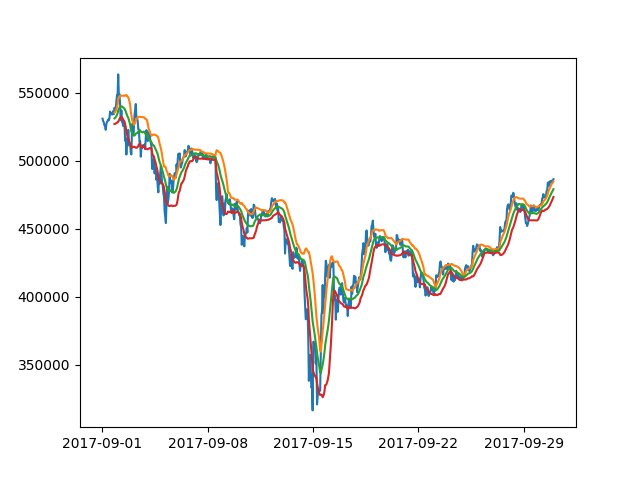

[[<matplotlib.lines.Line2D at 0x7f80b67afa90>],

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
data = hd.data()['Close']
x = data.index
y = data.values
sd = 1
upper, middle, lower = talib.BBANDS(data.values, timeperiod=20, matype=talib.MA_Type.SMA, nbdevup=sd, nbdevdn=sd)
[plt.plot(x, val) for val in [y, upper, middle, lower]]

In [ ]:
data.values

array([ 530988.,  529184.,  528301.,  526000.,  526119.,  522800.,
        526654.,  528600.,  529221.,  530312.,  529731.,  531199.,
        536200.,  534996.,  534999.,  533978.,  534329.,  536574.,
        534237.,  538993.,  538192.,  538244.,  543200.,  548180.,
        548200.,  563508.,  548007.,  549048.,  541463.,  529923.,
        537005.,  528498.,  528146.,  525500.,  528124.,  527075.,
        514779.,  516799.,  504591.,  515323.,  510900.,  522738.,
        513957.,  512897.,  512351.,  506037.,  504642.,  524753.,
        527519.,  519149.,  524215.,  533531.,  537500.,  541742.,
        531856.,  531479.,  529147.,  523179.,  523033.,  513630.,
        514333.,  502993.,  510085.,  509419.,  511441.,  510222.,
        510824.,  511948.,  508539.,  517634.,  522497.,  520261.,
        514471.,  517032.,  517365.,  521406.,  515790.,  512798.,
        510509.,  494000.,  494149.,  499184.,  501501.,  490721.,
        495100.,  492063.,  485965.,  489115.,  481067.,  4767

## References

- [Deep Q-LearningでFXしてみた](http://recruit.gmo.jp/engineer/jisedai/blog/deep-q-learning/)
- [slide](https://www.slideshare.net/JunichiroKatsuta/deep-qlearningfx)